# 数据预处理

In [ ]:
import numpy as np
import torch

time_step = 10
max_time = 5400

content = np.loadtxt("Data\students003.txt")
max_id = int(np.max(content[:, 1]))
max_time = int(np.max(content[:, 0]) / time_step) + 1

t_id_fxy = np.zeros((max_time, max_id, 2))

for l in content:
    t_id_fxy[int(l[0] / time_step), int(l[1] - 1), :] = l[-2:]

t_id_fxy = torch.from_numpy(t_id_fxy).float()
delta_xy = t_id_fxy[1:] - t_id_fxy[:-1]
delta_xy = torch.cat([torch.zeros(1, max_id, 2), delta_xy])
zero_idx = torch.argwhere(t_id_fxy[:, :, 0] == 0)
for z_idx in zero_idx:
    t, i = z_idx
    delta_xy[t, i, :] = 0
    if t < int(max_time / time_step):
        delta_xy[t + 1, i, :] = 0

t_id_fxy_vxvy = torch.cat([t_id_fxy, delta_xy], dim=-1)
torch.save(t_id_fxy_vxvy, "Data\\track.pt")

# 聚类

## k_means 聚类

In [1]:
import torch
import cv2
from src.clustering import k_means
from src.draw import Drawer

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
d = Drawer(min_x, max_x, min_y, max_y)

video_output = "Videos\\kmeans_1.mp4"
fps = 30
video = cv2.VideoWriter(video_output, 0, fps, (420, 380))

for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    if torch.sum(torch.abs(t[:, 2])) < 1e-4:
        t = t[:, :2]
    clu = k_means(t, k)

    canvas = d.draw(clu)
    video.write(canvas)

video.release()

In [ ]:
import torch
import cv2
from sklearn.cluster import KMeans
from src.draw import Drawer, org_data
import warnings

warnings.filterwarnings("ignore")

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
d = Drawer(min_x, max_x, min_y, max_y)
kmeans = KMeans(n_clusters=k, n_init=5)

video_output = "Videos\\kmeans_2.mp4"
fps = 30
video = cv2.VideoWriter(video_output, 0, fps, (420, 380))

for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    kmeans.fit(t)
    clu = org_data(t, kmeans.labels_)
    canvas = d.draw(clu)

    video.write(canvas)
video.release()

## DBSCAN 聚类

In [ ]:
import torch
import cv2
from sklearn.cluster import DBSCAN
from src.draw import Drawer, org_data

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

db = DBSCAN(eps=2, min_samples=1)
d = Drawer(min_x, max_x, min_y, max_y)

video_output = "Videos\\DBSAN.mp4"
fps = 30
video = cv2.VideoWriter(video_output, 0, fps, (420, 380))

for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    db.fit(t)
    clu = org_data(t, db.labels_)
    canvas = d.draw(clu)
    video.write(canvas)
video.release()

## 层次聚类

In [ ]:
import torch
import cv2
from sklearn.cluster import AgglomerativeClustering
from src.draw import Drawer, org_data

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
clustering = AgglomerativeClustering(n_clusters=5, linkage="ward")
d = Drawer(min_x, max_x, min_y, max_y)


video_output = "Videos\\AGNES.mp4"
fps = 30
video = cv2.VideoWriter(video_output, 0, fps, (420, 380))

for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    clustering.fit(t)
    clu = org_data(t, clustering.labels_)
    canvas = d.draw(clu)
    video.write(canvas)
video.release()

# 性能评估

##  Silhouette Coefficient (轮廓系数)

0.4924961 0.002577368


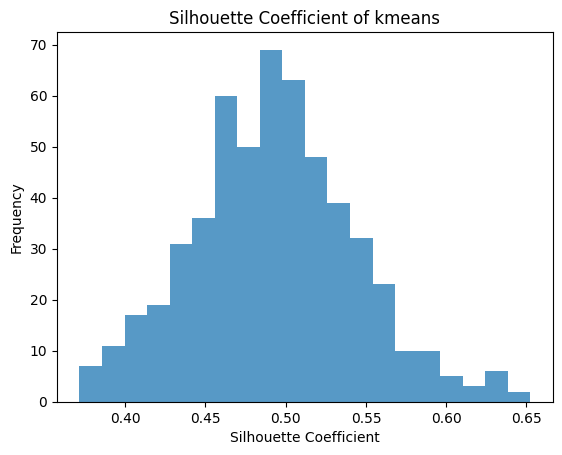

In [25]:
# kmeans

import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
kmeans = KMeans(n_clusters=k, n_init=5)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    kmeans.fit(t)
    score = silhouette_score(t, kmeans.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Silhouette Coefficient of kmeans')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Frequency')
plt.show()

0.38422927 0.014334049


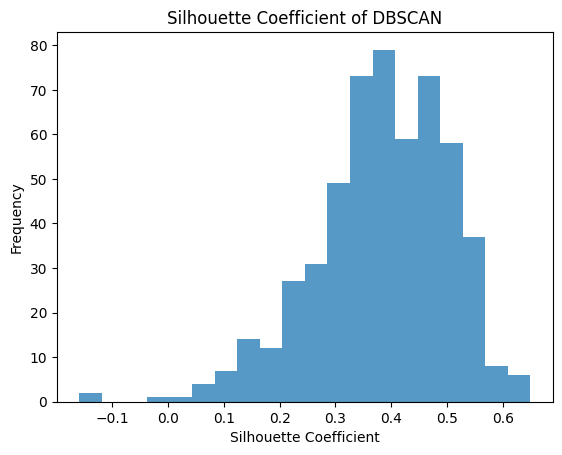

In [26]:
#DBSCAN

import torch
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

db = DBSCAN(eps=2, min_samples=1)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    db.fit(t)
    score = silhouette_score(t, db.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Silhouette Coefficient of DBSCAN')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Frequency')
plt.show()

0.48986128 0.0027688872


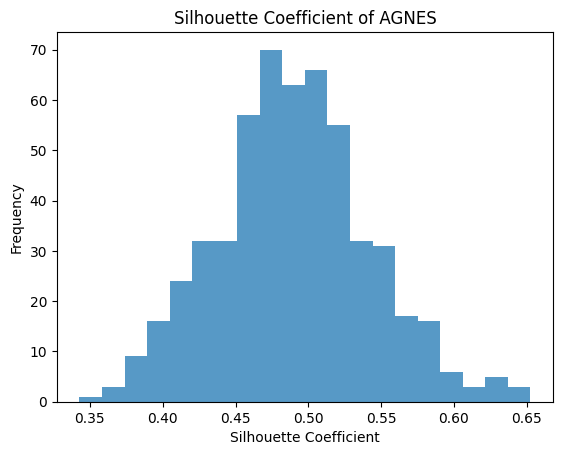

In [29]:
import torch
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
clustering = AgglomerativeClustering(n_clusters=5, linkage="ward")

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    clustering.fit(t)
    score = silhouette_score(t, clustering.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Silhouette Coefficient of AGNES')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Frequency')
plt.show()

## Calinski-Harabasz Index (CH指数)

53.92518314506673 207.69758207375983


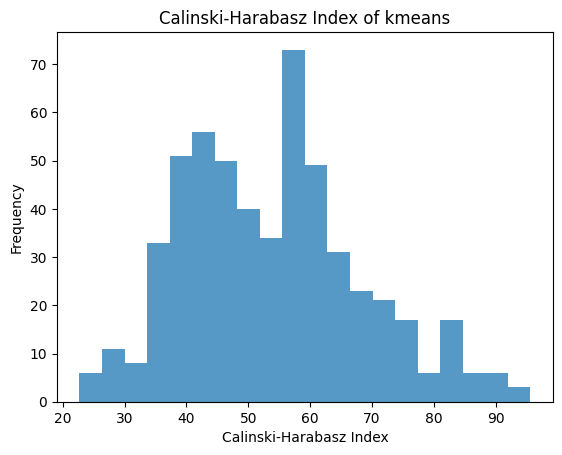

In [28]:
# kmeans

import torch
import numpy as np
from sklearn.cluster import KMeans

import warnings
from sklearn.metrics import calinski_harabasz_score

warnings.filterwarnings("ignore")

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
kmeans = KMeans(n_clusters=k, n_init=5)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    kmeans.fit(t)
    score = calinski_harabasz_score(t, kmeans.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Calinski-Harabasz Index of kmeans')
plt.xlabel('Calinski-Harabasz Index')
plt.ylabel('Frequency')
plt.show()

37.452212381819265 401.9897703562607


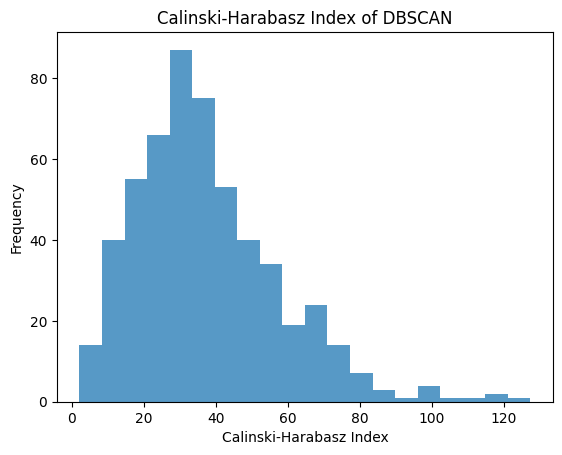

In [34]:
#DBSCAN

import torch
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

db = DBSCAN(eps=2, min_samples=1)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    db.fit(t)
    score = calinski_harabasz_score(t, db.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Calinski-Harabasz Index of DBSCAN')
plt.xlabel('Calinski-Harabasz Index')
plt.ylabel('Frequency')
plt.show()

51.98736182419591 199.49401264562454


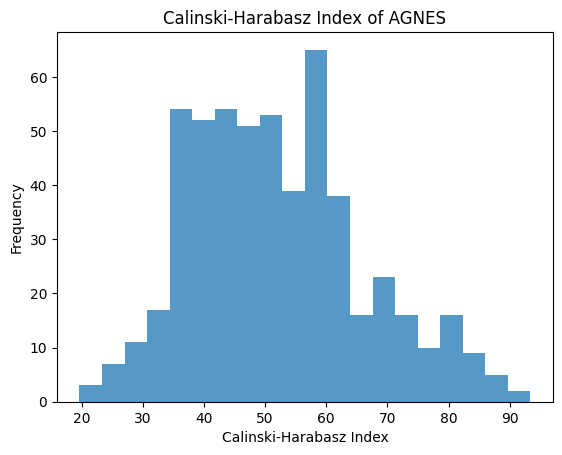

In [38]:
import torch
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
clustering = AgglomerativeClustering(n_clusters=5, linkage="ward")

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    clustering.fit(t)
    score = calinski_harabasz_score(t, clustering.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Calinski-Harabasz Index of AGNES')
plt.xlabel('Calinski-Harabasz Index')
plt.ylabel('Frequency')
plt.show()

## Davies-Bouldin Index (DB指数)

0.6271820045456447 0.009216918447429168


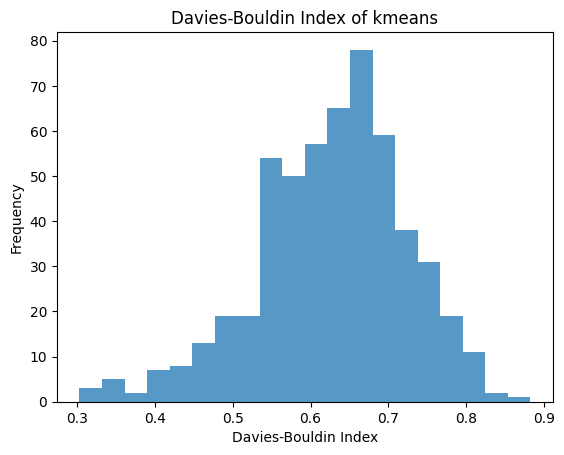

In [36]:
# kmeans

import torch
import numpy as np
from sklearn.cluster import KMeans

import warnings
from sklearn.metrics import davies_bouldin_score

warnings.filterwarnings("ignore")

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
kmeans = KMeans(n_clusters=k, n_init=5)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    kmeans.fit(t)
    score = davies_bouldin_score(t, kmeans.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Davies-Bouldin Index of kmeans')
plt.xlabel('Davies-Bouldin Index')
plt.ylabel('Frequency')
plt.show()

0.46107904851321596 0.00940301649467263


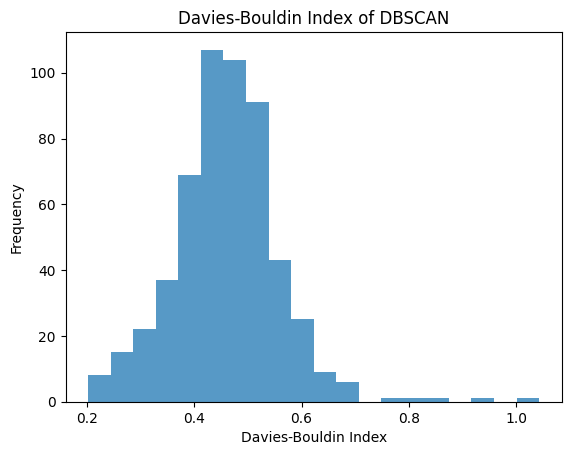

In [37]:
#DBSCAN

import torch
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

db = DBSCAN(eps=2, min_samples=1)

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    db.fit(t)
    score = davies_bouldin_score(t, db.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Davies-Bouldin Index of DBSCAN')
plt.xlabel('Davies-Bouldin Index')
plt.ylabel('Frequency')
plt.show()

0.6185842368130243 0.009941973333108835


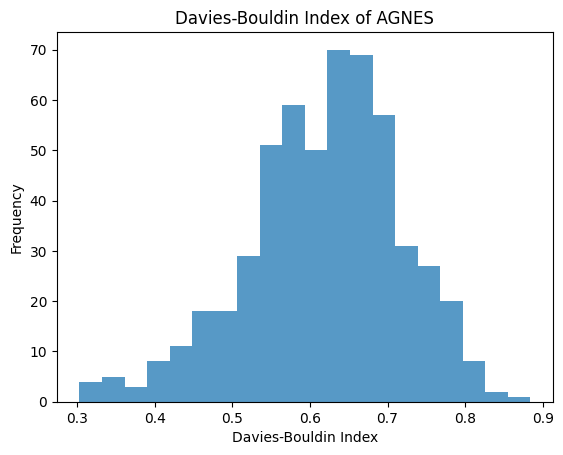

In [39]:
import torch
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

track = torch.load("Data\\track.pt")
max_x = torch.max(track[:, :, 0])
min_x = torch.min(track[:, :, 0])
max_y = torch.max(track[:, :, 1])
min_y = torch.min(track[:, :, 1])

k = 5
clustering = AgglomerativeClustering(n_clusters=5, linkage="ward")

scores=[]
for i in range(track.shape[0]):
    t = track[i]
    idx = torch.argwhere(t[:, 0] != 0)
    idx = idx[:, 0]
    t = t[idx]
    t = t[:, :2]
    clustering.fit(t)
    score = davies_bouldin_score(t, clustering.labels_)
    scores.append(score)

scores=np.array(scores)
print(np.mean(scores),np.var(scores))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Davies-Bouldin Index of AGNES')
plt.xlabel('Davies-Bouldin Index')
plt.ylabel('Frequency')
plt.show()

In [2]:
import cv2
import os
mp4_list=["Videos\kmeans_1.mp4","Videos\kmeans_2.mp4","Videos\DBSAN.mp4","Videos\AGNES.mp4"]


for i in range(len(mp4_list)):
    cap = cv2.VideoCapture(mp4_list[i])
    ret, frame = cap.read()
    cv2.imwrite(os.path.join("images",str(i)+".png"),frame)
    cap.release()